In [ ]:
!pip install torchdiffeq

## Neural ODE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm
import time


import matplotlib.pyplot as plt
%matplotlib inline

### In order to solve ODE, we have below two solvers

## 1)Euler Method (Fixed-step size solvers)

In [3]:
def euler(func, t, dt, y):
    return dt * func(t, y)    

## 2) Runge-Kutta method

In [4]:
def rk4(func, t, dt, y):
  _one_sixth = 1/6
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)
  
  return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth 

## NEURAL ODE

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, y0, t, solver):
        
        ## allocate solution tensor
        solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)

        ## store initial value at index 0
        solution[0] = y0

        j = 1
        for t0, t1 in zip(t[:-1], t[1:]):   ## each loop gives 2 consecutive time step (0,1), (1,2), (2,3)
            dy = solver(self.func, t0, t1 - t0, y0)

             ## y_new = y_old + derivative
            y1 = y0 + dy

             ## store result
            solution[j] = y1
            j += 1
            y0 = y1
        return solution

## Experiments 

### check NODE result by inputing cos(t), the output will be sin(t)

In [6]:
y0 = torch.Tensor([[0]]) ## two D- batch, dimension
t = torch.linspace(0, 6*np.pi, 1500) 

class cos(nn.Module):
    def forward(self, t, y):
        return torch.cos(t)

ode_test = NeuralODE(cos())
test_result = ode_test(y0=y0, t=t, solver=euler)

test_result = test_result.transpose(0, 1)


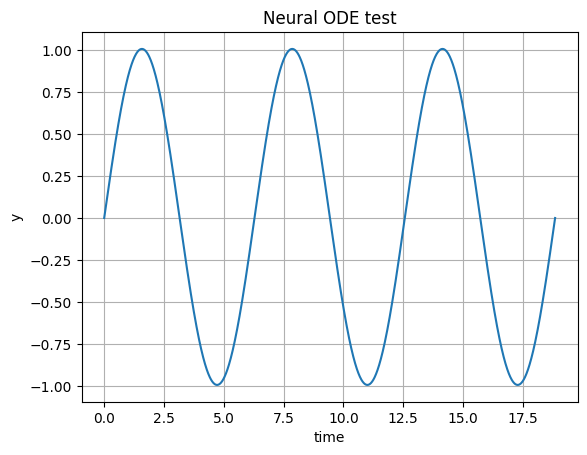

In [7]:
# visualize result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')
ax.set_xlabel('time')
ax.set_ylabel('y')
ax.plot(t.cpu().numpy(), test_result[0].detach().cpu().numpy())
plt.grid(True)
plt.show()

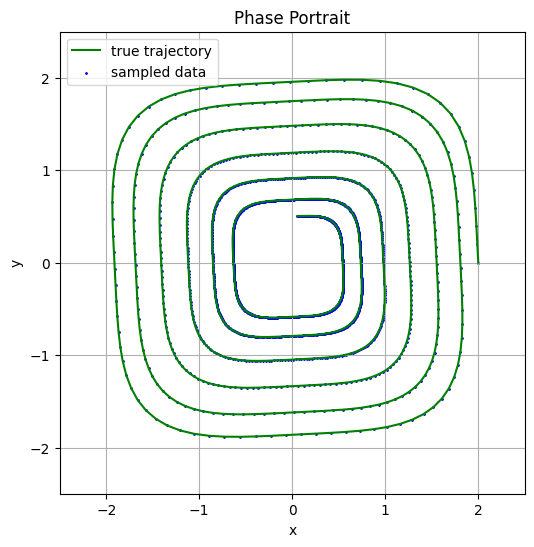

In [8]:
data_size = 2000

# generate toy dataset
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])


class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y**3, true_A)

with torch.no_grad():
  node = NeuralODE(func=Lambda())
  true_y = node(y0=true_y0, t=t, solver=euler)

def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_title('Phase Portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')
  ax.scatter(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], color='blue', label='sampled data', s=1)
  if pred_y is not None:
    ax.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'red', label='learned trajectory')
  ax.set_xlim(-2.5, 2.5)
  ax.set_ylim(-2.5, 2.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)


### Batch Processing

In [9]:
batch_time = 10
batch_size = 16

def get_batch():
    ## 16 random number
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype = np.int64), batch_size, replace=False))

    batch_y0 = true_y[s] ## the starting point 
    batch_t = t[:batch_time]

    ## the next 10 point of each start
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)

    return batch_y, batch_t, batch_y

## Neural ODE

In [10]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 50),
                                 nn.Tanh(),
                                 nn.Linear(50, 2))

        ## Randomly initialize the Weight

        for m in self.net.modules():
            if isinstance(m, nn.Linear): ## if m is nn
                 nn.init.normal_(m.weight, mean=0, std=0.1)
                 nn.init.constant_(m.bias, val=0)
                
    def forward(self, t, y):
        output = self.net(y**3) ## the y  is in y^3 times A in Lambda

        return output


## Training Pipeline

  0%|                                                   | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 1.224827


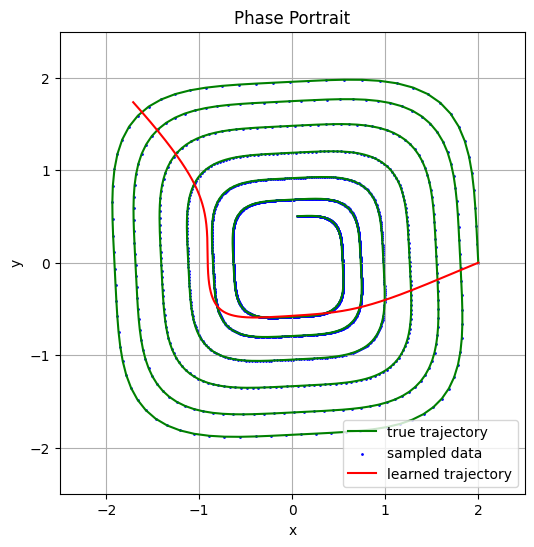

 12%|█████▏                                    | 50/401 [01:07<08:12,  1.40s/it]

Iter 0050 | Total Loss 0.732412


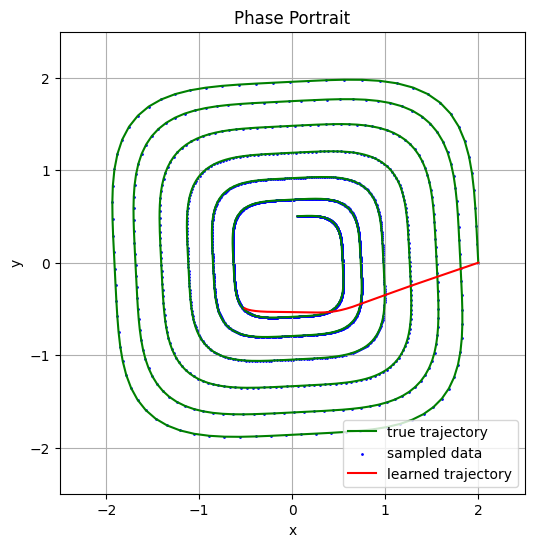

 25%|██████████▏                              | 100/401 [02:15<06:36,  1.32s/it]

Iter 0100 | Total Loss 0.658142


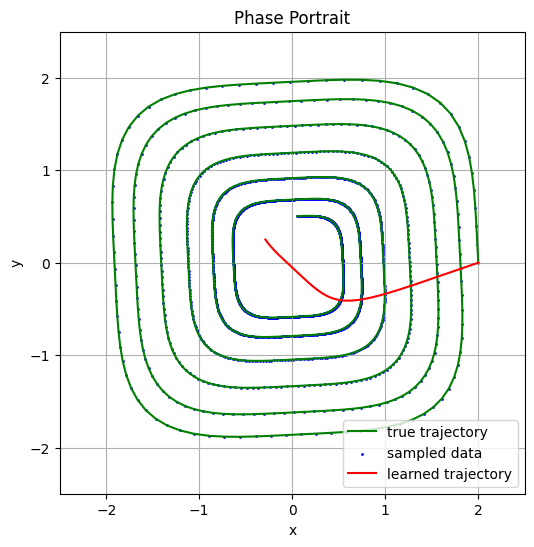

 37%|███████████████▎                         | 150/401 [03:24<05:34,  1.33s/it]

Iter 0150 | Total Loss 0.697935


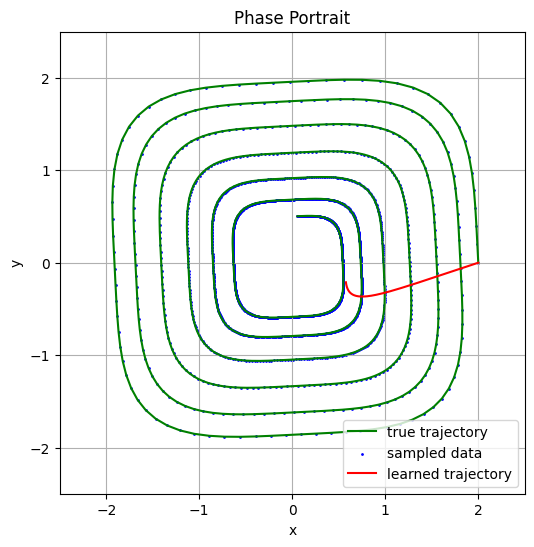

 50%|████████████████████▍                    | 200/401 [04:31<04:30,  1.34s/it]

Iter 0200 | Total Loss 0.660928


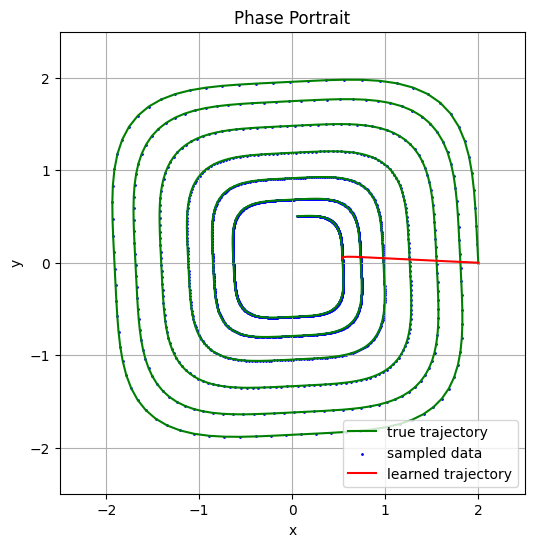

 62%|█████████████████████████▌               | 250/401 [05:49<04:28,  1.78s/it]

Iter 0250 | Total Loss 1.118745


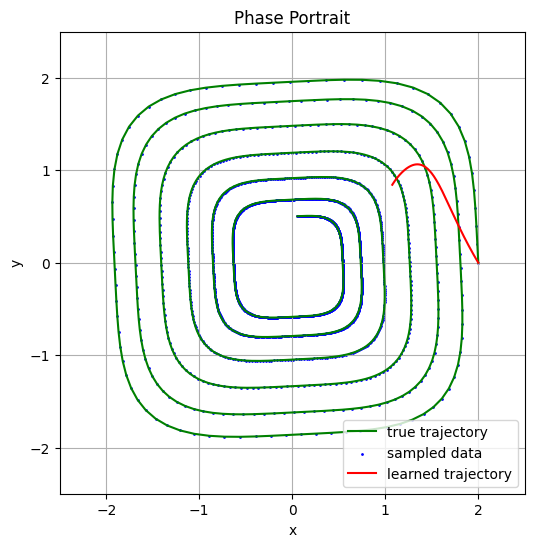

 75%|██████████████████████████████▋          | 300/401 [07:03<02:30,  1.49s/it]

Iter 0300 | Total Loss 1.067470


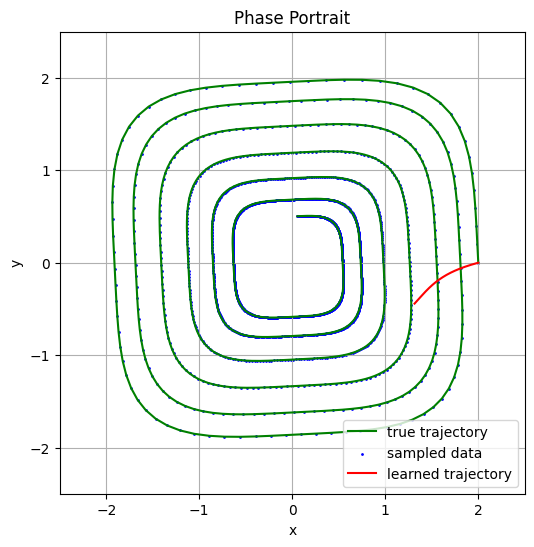

 87%|███████████████████████████████████▊     | 350/401 [08:21<01:13,  1.44s/it]

Iter 0350 | Total Loss 1.281209


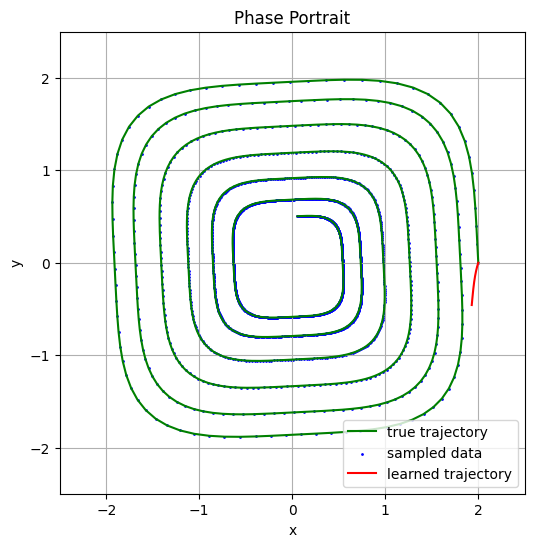

100%|████████████████████████████████████████▉| 400/401 [09:41<00:01,  1.61s/it]

Iter 0400 | Total Loss 1.200282


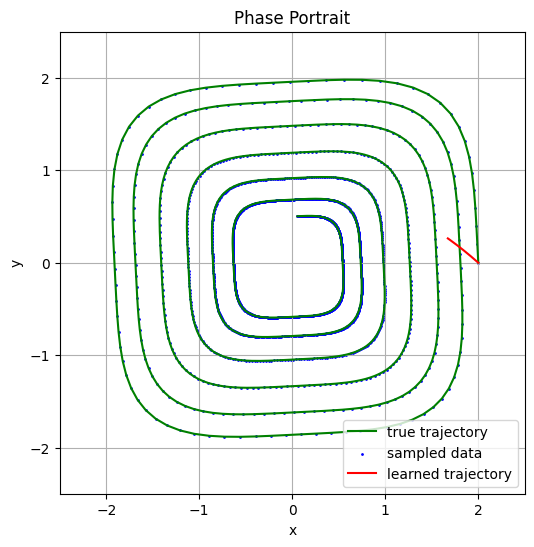

100%|█████████████████████████████████████████| 401/401 [09:43<00:00,  1.46s/it]

process time: 583.5307862758636 sec


In [12]:
niters = 400

node = NeuralODE(func = ODEFunc()) ## contain ODEFUNC (NN) + integration

optimizer = optim.RMSprop(node.parameters()) ## update NN weight

start_time = time.time()

for iter in tqdm(range(niters + 1)):

    ## clear the previous gradient
    optimizer.zero_grad()

    ## get the processed batch
    batch_y0, batch_t, batch_y = get_batch()

    pred_y = node(y0=batch_y0, t=t, solver=rk4)

    loss = torch.mean(torch.abs(pred_y - batch_y))

    loss.backward()

    optimizer.step() ## update the gradient 

    if iter % 50 == 0:  ## visualize the loss every 50 iter
        with torch.no_grad(): ## dont compute gradietn
          pred_y = node(true_y0, t=t, solver=rk4)
          loss = torch.mean(torch.abs(pred_y - true_y))
          print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
          visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))


## Hybrid Model of Neural ODE + Markov Chain Using Soft Assignment Method

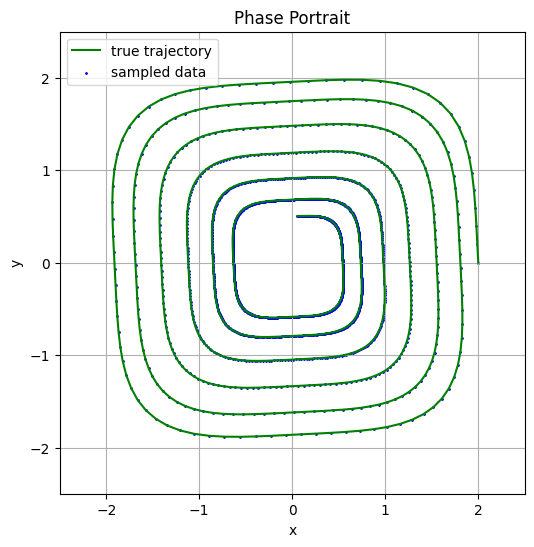


%|                                                   | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 15.003098


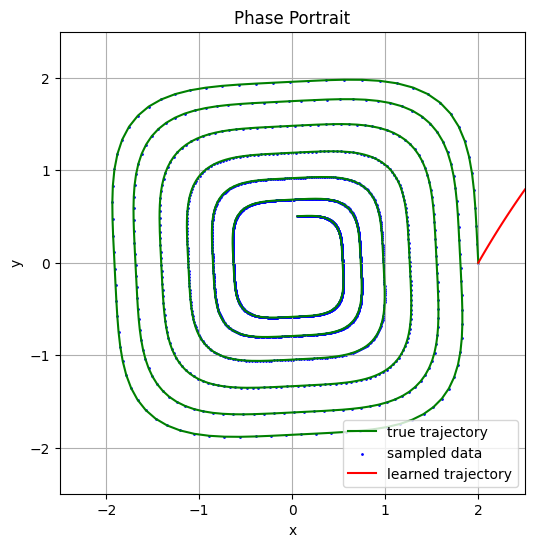


%|                                           | 1/401 [00:00<03:11,  2.09it/s]
%|█▍                                        | 14/401 [00:00<00:12, 30.99it/s]
%|██▊                                       | 27/401 [00:00<00:06, 54.80it/s]
%|████▏                                     | 40/401 [00:00<00:04, 73.95it/s]

Iter 0050 | Total Loss 0.666050


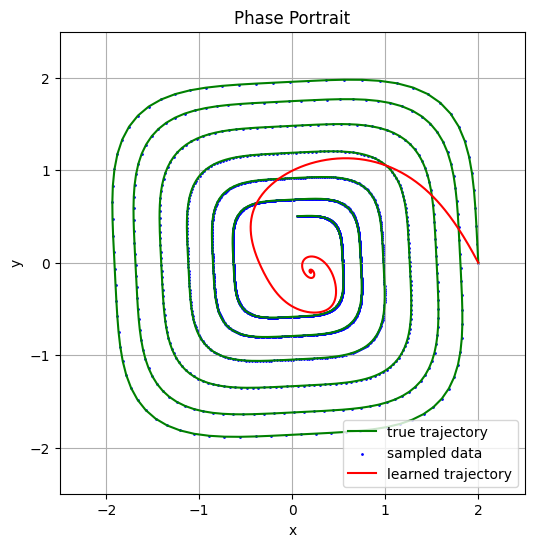


%|█████▎                                    | 51/401 [00:01<00:09, 37.92it/s]
%|██████▌                                   | 63/401 [00:01<00:06, 49.97it/s]
%|███████▉                                  | 76/401 [00:01<00:05, 63.34it/s]
%|█████████▎                                | 89/401 [00:01<00:04, 75.54it/s]

Iter 0100 | Total Loss 0.684327


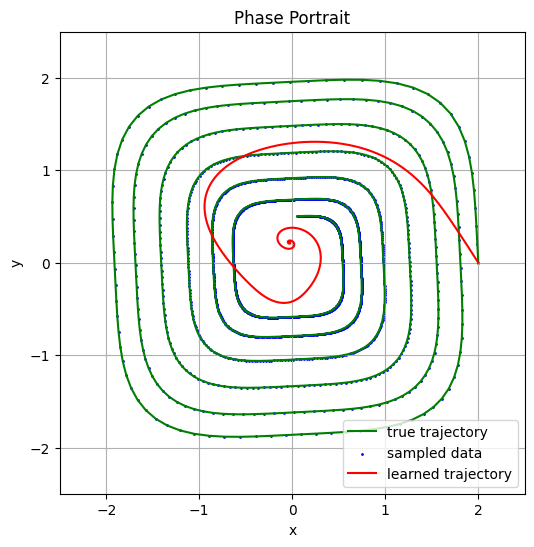


%|██████████▎                              | 101/401 [00:02<00:07, 42.50it/s]
%|███████████▌                             | 113/401 [00:02<00:05, 52.77it/s]
%|████████████▉                            | 126/401 [00:02<00:04, 64.39it/s]
%|██████████████                           | 138/401 [00:02<00:03, 74.58it/s]
%|███████████████▎                         | 150/401 [00:02<00:02, 84.05it/s]

Iter 0150 | Total Loss 0.703737


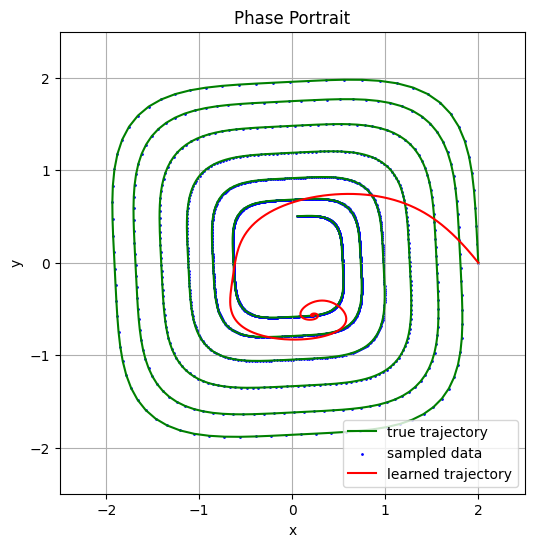


%|████████████████▌                        | 162/401 [00:03<00:05, 44.16it/s]
%|█████████████████▉                       | 175/401 [00:03<00:04, 55.37it/s]
%|███████████████████▏                     | 188/401 [00:03<00:03, 66.91it/s]

Iter 0200 | Total Loss 0.747526


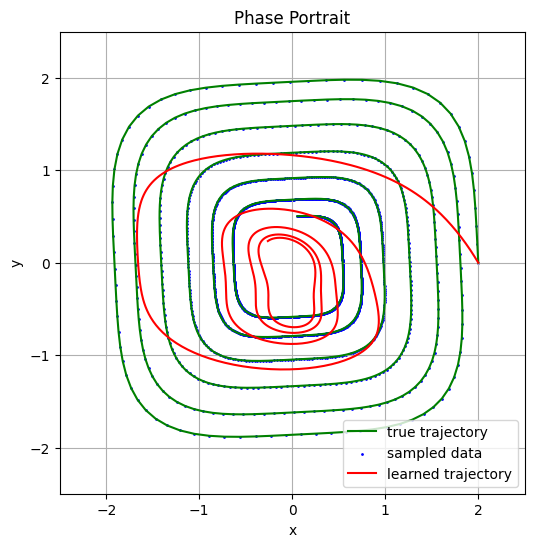


%|████████████████████▌                    | 201/401 [00:03<00:04, 41.78it/s]
%|█████████████████████▉                   | 214/401 [00:04<00:03, 52.24it/s]
%|███████████████████████▏                 | 227/401 [00:04<00:02, 63.40it/s]
%|████████████████████████▌                | 240/401 [00:04<00:02, 74.52it/s]

Iter 0250 | Total Loss 0.705393


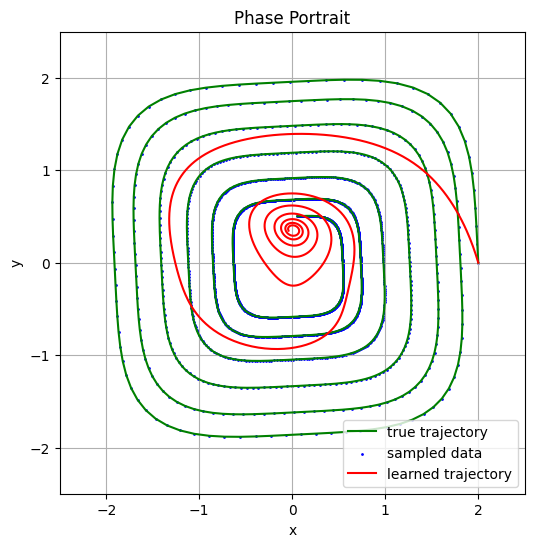


%|█████████████████████████▋               | 251/401 [00:04<00:03, 42.93it/s]
%|██████████████████████████▉              | 263/401 [00:04<00:02, 52.92it/s]
%|████████████████████████████▏            | 276/401 [00:05<00:01, 64.50it/s]
%|█████████████████████████████▌           | 289/401 [00:05<00:01, 75.80it/s]

Iter 0300 | Total Loss 0.728556


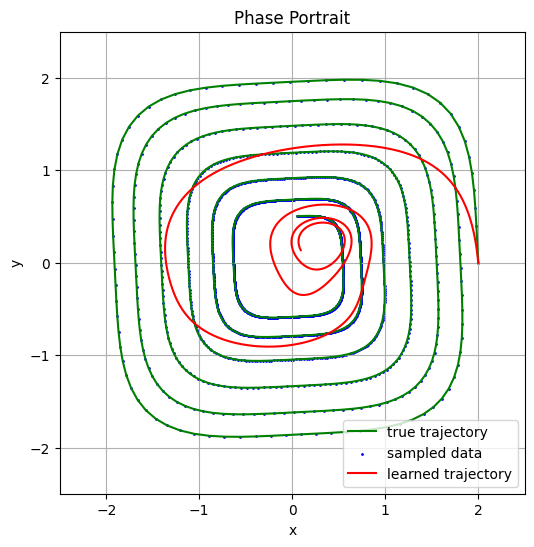


%|██████████████████████████████▊          | 301/401 [00:05<00:02, 43.56it/s]
%|████████████████████████████████         | 314/401 [00:05<00:01, 54.37it/s]
%|█████████████████████████████████▍       | 327/401 [00:05<00:01, 65.50it/s]
%|██████████████████████████████████▊      | 340/401 [00:06<00:00, 76.61it/s]

Iter 0350 | Total Loss 0.749495


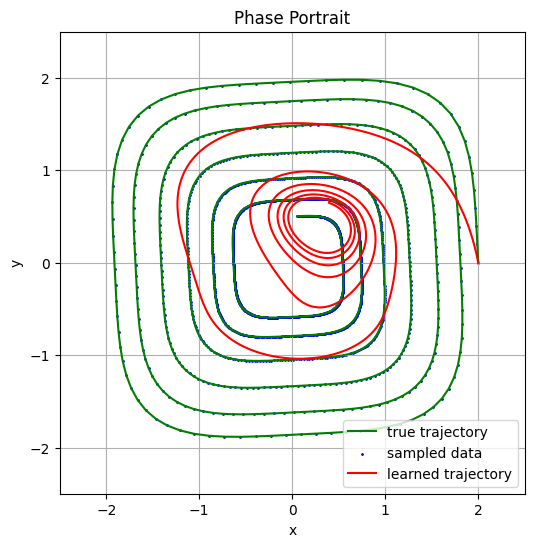


%|███████████████████████████████████▉     | 351/401 [00:06<00:01, 43.43it/s]
%|█████████████████████████████████████    | 363/401 [00:06<00:00, 53.41it/s]
%|██████████████████████████████████████▎  | 375/401 [00:06<00:00, 63.85it/s]
%|███████████████████████████████████████▋ | 388/401 [00:06<00:00, 75.41it/s]

Iter 0400 | Total Loss 0.714797


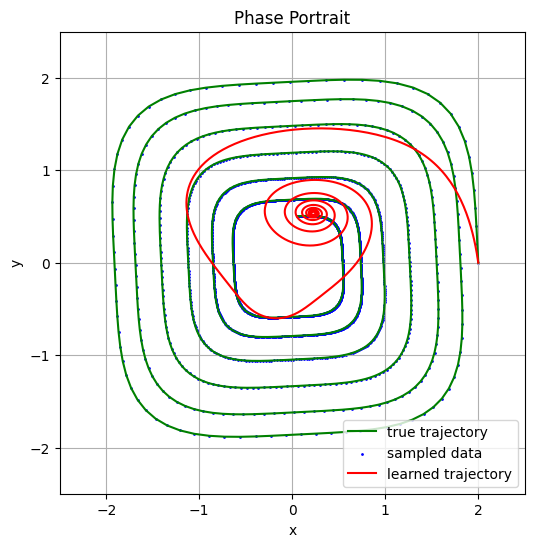


100%|█████████████████████████████████████████| 401/401 [00:07<00:00, 53.69it/s]

Process time: 7.47 sec


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

%matplotlib inline

# -----------------------------
# Integration solvers
# -----------------------------
def euler(func, t, dt, y):
    return dt * func(t, y)

def rk4(func, t, dt, y):
    _one_sixth = 1/6
    half_dt = dt * 0.5

    k1 = func(t, y)
    k2 = func(t + half_dt, y + half_dt * k1)
    k3 = func(t + half_dt, y + half_dt * k2)
    k4 = func(t + dt, y + dt * k3)

    return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth

# -----------------------------
# Neural ODE wrapper
# -----------------------------
class NeuralODE(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, y0, t, solver):
        solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
        solution[0] = y0

        j = 1
        for t0, t1 in zip(t[:-1], t[1:]):
            dy = solver(self.func, t0, t1 - t0, y0)
            y1 = y0 + dy
            solution[j] = y1
            j += 1
            y0 = y1

        return solution

# -----------------------------
# Spiral dataset
# -----------------------------
data_size = 2000
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    node_true = NeuralODE(func=Lambda())
    true_y = node_true(y0=true_y0, t=t, solver=euler)

# -----------------------------
# Visualization
# -----------------------------
def visualize(true_y, pred_y=None):
    fig = plt.figure(figsize=(6, 6), facecolor='white')
    ax = fig.add_subplot(111)
    ax.set_title('Phase Portrait')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # true trajectory
    ty = true_y.cpu().numpy()
    if ty.ndim == 3:  # (time, batch, dim)
        ax.plot(ty[:, 0, 0], ty[:, 0, 1], 'green', label='true trajectory')
        ax.scatter(ty[:, 0, 0], ty[:, 0, 1], color='blue', label='sampled data', s=1)
    else:
        ax.plot(ty[:, 0], ty[:, 1], 'green', label='true trajectory')
        ax.scatter(ty[:, 0], ty[:, 1], color='blue', label='sampled data', s=1)

    # predicted trajectory
    if pred_y is not None:
        py = pred_y.cpu().numpy()
        if py.ndim == 4:  # (time, batch, 1, dim)
            ax.plot(py[:, 0, 0, 0], py[:, 0, 0, 1], 'red', label='learned trajectory')
        elif py.ndim == 3:  # (time, batch, dim)
            ax.plot(py[:, 0, 0], py[:, 0, 1], 'red', label='learned trajectory')
        else:
            ax.plot(py[:, 0], py[:, 1], 'red', label='learned trajectory')

    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize(true_y)

# -----------------------------
# Batch preparation
# -----------------------------
batch_time = 10
batch_size = 16

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]                     # starting points
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)
    return batch_y0, batch_t, batch_y

# -----------------------------
# Hybrid Markov Neural ODE
# -----------------------------
# Simple encoder/decoder
class Encoder(nn.Module):
    def __init__(self, dim=2, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim, 32), nn.Tanh(), nn.Linear(32, latent_dim))
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=2, dim=2):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(latent_dim, 32), nn.Tanh(), nn.Linear(32, dim))
    def forward(self, z):
        return self.net(z)

class RegimeODE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(latent_dim, 16), nn.Tanh(), nn.Linear(16, latent_dim))
    def forward(self, t, z):
        return self.net(z)

# Hybrid Markov ODE function
class HybridMarkovODEFunc(nn.Module):
    def __init__(self, latent_dim=2, num_regimes=3):
        super().__init__()
        self.num_regimes = num_regimes
        self.encoder = Encoder(dim=2, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, dim=2)
        self.regime_linear = nn.Linear(latent_dim, num_regimes)
        self.regimes = nn.ModuleList([RegimeODE(latent_dim) for _ in range(num_regimes)])

    def infer_regime(self, z):
        p = torch.softmax(self.regime_linear(z), dim=-1)  # (batch, num_regimes)
        return p

    def forward(self, t, x):
        batch_size, _, dim = x.shape
        x_flat = x.view(batch_size, dim)             # (batch, dim) flatten it as encoder work in 2D tensor
        z = self.encoder(x_flat)                     # (batch, latent_dim)
        p = self.infer_regime(z)                     # (batch, num_regimes)

        # compute regime derivatives
        dz_all = torch.stack([r(t, z) for r in self.regimes], dim=-1)  # (batch, latent_dim, num_regimes)
        p = p.unsqueeze(1)                     # (batch, 1, num_regimes)
        dz = torch.sum(dz_all * p, dim=-1)     # (batch, latent_dim)

        dx = self.decoder(dz)                   # (batch, dim)
        dx = dx.view(batch_size, 1, dim)       # (batch, 1, dim)
        return dx

# -----------------------------
# Training
# -----------------------------
niters = 400
node = NeuralODE(func = HybridMarkovODEFunc(latent_dim=2, num_regimes=3))
optimizer = optim.RMSprop(node.parameters())
start_time = time.time()

for iter in tqdm(range(niters + 1)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = node(y0=batch_y0, t=batch_t, solver=rk4)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if iter % 50 == 0:
        with torch.no_grad():
            pred_y_full = node(true_y0.unsqueeze(1), t, solver=rk4)
            loss_full = torch.mean(torch.abs(pred_y_full - true_y))
            print(f'Iter {iter:04d} | Total Loss {loss_full:.6f}')
            visualize(true_y, pred_y_full)

end_time = time.time() - start_time
print('Process time: {:.2f} sec'.format(end_time))

